In [23]:
import math
from tqdm import tqdm
import torch
from torch import Tensor, nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR

from typing import Union, Tuple, List, Optional, Callable, Any
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader

import sys
from pathlib import Path
# Go up one level from training_scripts/ to the project root
project_root = Path().resolve().parent
sys.path.append(str(project_root))

%load_ext autoreload
%autoreload 2

from smc.smc import sequential_monte_carlo
from smc.sampling_algorithms import (
    systematic_resample,
    stratified_resample,
    multinomial_resample
)
from smc.utils import lambda_schedule
from datasets import checkerboard

from smc_scripts.plot_utils import plot_smc_results_checkerboard

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

import torch
import random
import torch.backends.cudnn as cudnn

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


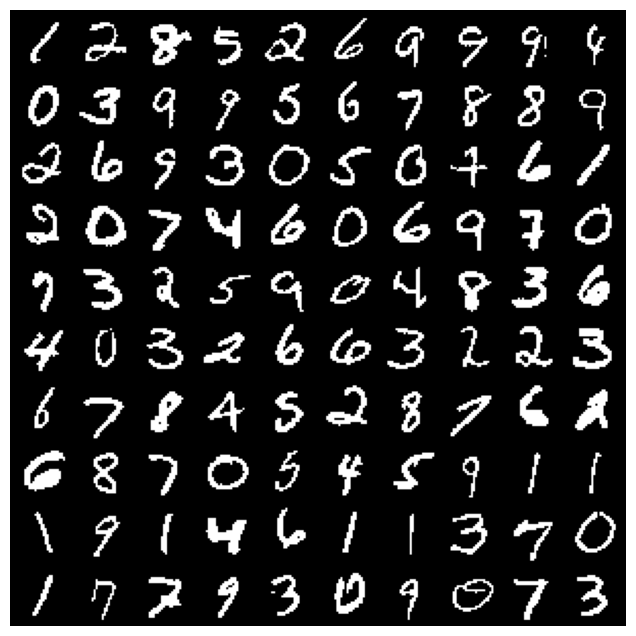

In [24]:
from datasets.binarized_mnist import build_dataloaders
train_loader, test_loader = build_dataloaders(batch_size=100, add_noise=False)

# Visualize samples
images, labels = next(iter(train_loader))

# Make a grid of images
grid = utils.make_grid(images, nrow=10, padding=2)

# Plot the grid
plt.figure(figsize=(8,8))
plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap="gray")
plt.axis('off')
plt.show()

In [29]:
from models.reward_models.binarized_mnist_classifier import BinarizedMNISTClassifier
import torch

batch_size = 64
epochs = 10
lr = 1e-3

model = BinarizedMNISTClassifier().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [26]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"# Trainable parameters: {count_parameters(model):,}")

# Trainable parameters: 917,898


Epoch 1/10 | Train Loss: 0.1364, Accuracy: 95.72% | Test Loss: 0.0378, Accuracy: 98.83% | LR: 0.00100000
Epoch 2/10 | Train Loss: 0.0432, Accuracy: 98.68% | Test Loss: 0.0309, Accuracy: 98.93% | LR: 0.00100000
Epoch 3/10 | Train Loss: 0.0300, Accuracy: 99.08% | Test Loss: 0.0350, Accuracy: 98.92% | LR: 0.00100000
Epoch 4/10 | Train Loss: 0.0234, Accuracy: 99.26% | Test Loss: 0.0331, Accuracy: 98.91% | LR: 0.00100000
Epoch 5/10 | Train Loss: 0.0183, Accuracy: 99.43% | Test Loss: 0.0414, Accuracy: 98.73% | LR: 0.00100000
Epoch 6/10 | Train Loss: 0.0155, Accuracy: 99.49% | Test Loss: 0.0336, Accuracy: 99.08% | LR: 0.00100000


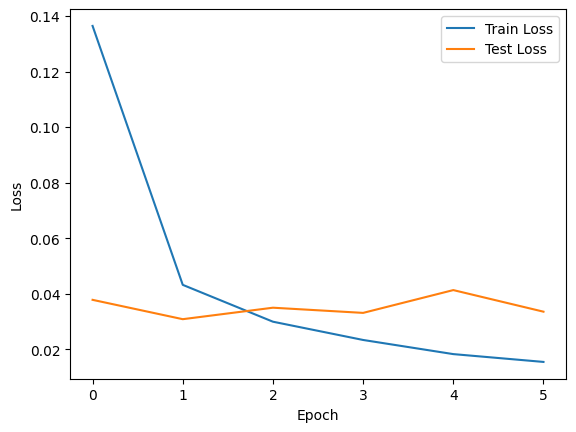

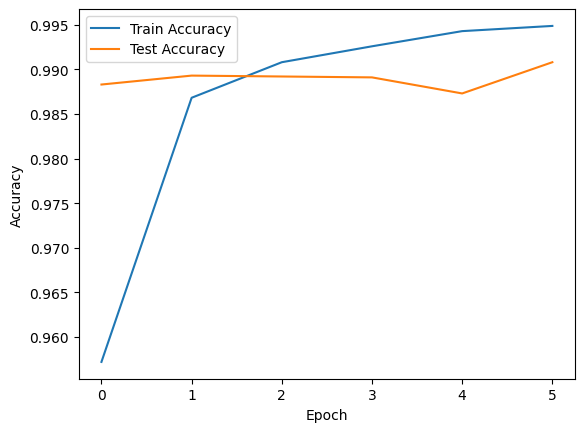

In [30]:
from datasets.binarized_mnist import build_dataloaders

train_loader, test_loader = build_dataloaders(batch_size=batch_size, add_noise=False)

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for x, labels in train_loader:
        x = F.one_hot(x.long(), num_classes=2).float().to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss /= len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    with torch.no_grad():
        test_loss = 0
        correct = 0
        total = 0
        for x, labels in test_loader:
            x = F.one_hot(x.long(), num_classes=2).float().to(device)
            labels = labels.to(device)
            
            logits = model(x)
            loss = criterion(logits, labels)
            test_loss += loss.item()
            
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        test_loss /= len(test_loader)
        test_acc = correct / total
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

    print(f"Epoch {epoch + 1}/{epochs} | "
          f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc * 100:.2f}% | "
          f"Test Loss: {test_loss:.4f}, Accuracy: {test_acc * 100:.2f}% | "
          f"LR: {optimizer.param_groups[0]['lr']:.8f}")
    
    if test_acc > 0.99:
        break

plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [31]:
# store model weights
torch.save(model.state_dict(), '../model_weights/binarized_mnist_classifier_1.pth')